In [51]:
# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import PercentFormatter

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torchinfo import summary
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle

In [52]:
# Ensure we're working in the directory of this file
os.chdir('c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface')
initial_wd = os.getcwd()

# Latex fonts
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [53]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force*10**-6

def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    E = E * 10**3 # kPa to Pa
    i = i * 10**-9 # nm to m
    r = r * 10**-9 # nm to m
    gamma = gamma * 10**-6 # microJ/m^2 to J/m^2
    E_eff = E / (1 - nu**2)
    K = 4/3 * E_eff
    Ua = np.sqrt(6*np.pi*gamma)
    # JKR force formula in (3)
    force = K * r **0.5 * i**1.5 - Ua * K**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    # return force*10**-6
    return force*10**9

In [54]:
# resolution of the map
res = 200
# random values
size = res * res

# Seed (if needed)
np.random.seed(42)

# Triangular distrbution
E = np.random.triangular(left=0.2, mode=1.8, right=10, size=size)

# Poisson's ratio 
nu = 0.5

# surface energy
gamma = abs(np.random.uniform(low=1., high=3., size=size))

# radius of the indenter
r = 1980.0 # (nm)

In [55]:
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-800, 0, 3)

'''DISPLACEMENT VECTORS'''
xmin, xmax, npts = 0, 150, 50

'''Uniformly distributed disp. vectors'''
# indentation depth. more points
contact = np.linspace(xmin, xmax, npts+1)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])

'''Randomly distributed disp. vectors'''
# Seed (if needed)
np.random.seed(42)

rnd_contact_list = [contact]
for _ in range(size-1):
    aux = np.random.random(npts+1).cumsum()
    aux = (aux-aux.min()) / aux.ptp()     #... .ptp(): peak to peak, i.e., xmax-xmin
    aux = (xmax-xmin)*aux + xmin
    rnd_contact_list.append(aux)
rnd_contact = np.array(rnd_contact_list)
rnd_approach = np.concatenate([np.repeat([no_contact[:-1]], size, axis=0), rnd_contact], axis=1)
rnd_withdraw = np.flip(rnd_approach, axis=1)

# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])

In [56]:
# construct dataframe
df = pd.DataFrame()
# 'E' and 'gamma' arrays to list:
df['E'] = E.tolist()
df['gamma'] = gamma.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [rnd_approach[app] for app in range(len(df))]
df['withdraw'] = [rnd_withdraw[wd] for wd in range(len(df))]
# '..._interp' columns have the sole purpose of allowing the sns errorbar plot 
df['approach_interp'] = [approach for _ in range(len(df))]
df['withdraw_interp'] = [withdraw for _ in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, x.gamma, r), axis=1)
df['f_hertz_interp'] = df.apply(lambda x: np.interp(x.approach_interp, x.approach, x.f_hertz), axis=1)
df['f_jkr_interp'] = df.apply(lambda x: np.interp(-x.withdraw_interp, -x.withdraw, x.f_jkr), axis=1)

C:\Users\luisr\AppData\Local\Temp\ipykernel_19468\566930558.py:25: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
C:\Users\luisr\AppData\Local\Temp\ipykernel_19468\566930558.py:59: RuntimeWarning: invalid value encountered in power
  force = K * r **0.5 * i**1.5 - Ua * K**0.5 * r**0.75 * i**0.75


# **JKR**

In [57]:
#df_jkr: dataframe for jkr data
df_jkr = pd.DataFrame()
df_jkr['withdraw'] = df['withdraw'].copy()
df_jkr['withdraw_contact'] = df_jkr['withdraw'].copy().apply(lambda x: x[x>0])
df_jkr['f_jkr'] = df['f_jkr'].copy()
df_jkr['f_jkr_contact'] = df_jkr['f_jkr'].copy().apply(lambda x: x[:-(len(no_contact))])
df_jkr['E_jkr'] = df['E'].copy()
df_jkr['gamma_jkr'] = df['gamma'].copy()

#check size of indentation and force vectors
print(df_jkr['withdraw_contact'][0].shape, df_jkr['f_jkr_contact'][0].shape)

(50,) (50,)


In [58]:
df_jkr.head(), print(len(df_jkr))

40000


(                                            withdraw  \
 0  [150.0, 147.0, 144.0, 141.0, 138.0, 135.0, 132...   
 1  [150.0, 143.64657852132757, 142.4352780999585,...   
 2  [150.0, 145.96271699783, 145.76333541182936, 1...   
 3  [150.0, 149.10283749624375, 147.6195141561324,...   
 4  [150.0, 144.79045779182758, 143.8533839693698,...   
 
                                     withdraw_contact  \
 0  [150.0, 147.0, 144.0, 141.0, 138.0, 135.0, 132...   
 1  [150.0, 143.64657852132757, 142.4352780999585,...   
 2  [150.0, 145.96271699783, 145.76333541182936, 1...   
 3  [150.0, 149.10283749624375, 147.6195141561324,...   
 4  [150.0, 144.79045779182758, 143.8533839693698,...   
 
                                                f_jkr  \
 0  [0.26414709113338425, 0.25391007093358003, 0.2...   
 1  [0.9367124928571328, 0.870804937256369, 0.8584...   
 2  [0.5880142576844827, 0.5606480463863339, 0.559...   
 3  [0.4493295633329905, 0.4445061259459816, 0.436...   
 4  [0.1403291245805178, 0.

### Inputs and labels

In [59]:
'''x_jkr = np.array(df_jkr[['withdraw_contact', 'f_jkr_contact']])
y_jkr = np.array(df_jkr[['E_jkr','gamma_jkr']])
print(x_jkr.shape, y_jkr.shape)'''

"x_jkr = np.array(df_jkr[['withdraw_contact', 'f_jkr_contact']])\ny_jkr = np.array(df_jkr[['E_jkr','gamma_jkr']])\nprint(x_jkr.shape, y_jkr.shape)"

### Splitting data into 6 folds

In [60]:
def tensor_input_shape(nparray):
    '''
    Training and test data from np arrays to torch tensor with desired shape
    Input: nparray - numpy array with two dimensions (n_samples, n_features)
    Output: torch_tensor - pytorch tensor with 3 dimensions (n_samples, n_pts, n_features) 
    '''
    n_samples = len(nparray)
    n_pts = len(nparray[0,0])
    torch_tensor = torch.zeros(size=(n_samples, n_pts, 2))
    for i in range(n_samples):
        aux_nparray = np.hstack((np.array(nparray[i,0]).reshape((n_pts,1)), np.array(nparray[i,1]).reshape((n_pts,1))))
        aux_ttensor = torch.from_numpy(aux_nparray).type(torch.float)
        torch_tensor[i,:,:] = aux_ttensor
    return torch_tensor

In [61]:
test_ratio = 0.15
rnd_state = None

target_cols = ['E_jkr_cat', 'gamma_jkr_cat']
nbins = 30

# Training-Test Split
while nbins >= 1:
    print(nbins)
    try:
        df_jkr['E_jkr_cat'] = pd.cut(df_jkr['E_jkr'], bins=nbins)
        df_jkr['gamma_jkr_cat'] = pd.cut(df_jkr['gamma_jkr'], bins=nbins)
        train_df_jkr, test_df_jkr = train_test_split(df_jkr, test_size=test_ratio, 
                                             stratify=df_jkr[target_cols], random_state=rnd_state)
        break
    except:
        nbins += -1

skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=rnd_state)
# Combine categorical target variables into one column
train_df_jkr['combined_targets'] = train_df_jkr['E_jkr_cat'].astype(str) + '_' + train_df_jkr['gamma_jkr_cat'].astype(str)

train_list, valid_list = [], []

for i, (train_index, test_index) in enumerate(skf.split(train_df_jkr, train_df_jkr['combined_targets'])):
    print(f"Split {i+1}")
    # Extract target values for the current fold
    train_fold = np.array(train_df_jkr[['withdraw_contact', 'f_jkr_contact','E_jkr', 'gamma_jkr']].iloc[train_index])
    train_list.append(train_fold)
    valid_fold = np.array(train_df_jkr[['withdraw_contact', 'f_jkr_contact','E_jkr', 'gamma_jkr']].iloc[test_index])
    valid_list.append(valid_fold)

# Test data to tensors
ft_cols = ['withdraw_contact', 'f_jkr_contact']
lb_cols = ['E_jkr', 'gamma_jkr']
x_test_jkr = np.array(test_df_jkr[ft_cols])
y_test_jkr = np.array(test_df_jkr[lb_cols])
x_test_t_jkr = tensor_input_shape(x_test_jkr)
y_test_t_jkr = torch.from_numpy(y_test_jkr).type(torch.float)
print(f"Shape of the test tensors (x, y): {x_test_t_jkr.shape, y_test_t_jkr.shape}")

30
29
28
27
26
25


c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\venv\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Shape of the test tensors (x, y): (torch.Size([6000, 50, 2]), torch.Size([6000, 2]))


In [62]:
# Do this for each fold in the CV loop
train_idx, test_idx = next(skf.split(train_df_jkr, train_df_jkr['combined_targets']))
print(f"Shape of the split outputs (train, valid): {train_idx.shape, test_idx.shape}")
train_data = train_df_jkr.iloc[train_idx]
valid_data = train_df_jkr.iloc[test_idx]
print(f"Shape of the training and validation folds: {train_data.shape, valid_data.shape}")
x_train = np.array(train_data[['withdraw_contact', 'f_jkr_contact']])
y_train = np.array(train_data[['E_jkr', 'gamma_jkr']])
print(f"Shape of the training arrays (x, y): {x_train.shape, y_train.shape}")
x_train_t = tensor_input_shape(x_train)
y_train_t = torch.from_numpy(y_train).type(torch.float)
print(f"Shape of the training tensors (x, y): {x_train_t.shape, y_train_t.shape}")

Shape of the split outputs (train, valid): ((28333,), (5667,))
Shape of the training and validation folds: ((28333, 9), (5667, 9))
Shape of the training arrays (x, y): ((28333, 2), (28333, 2))


c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\venv\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


Shape of the training tensors (x, y): (torch.Size([28333, 50, 2]), torch.Size([28333, 2]))


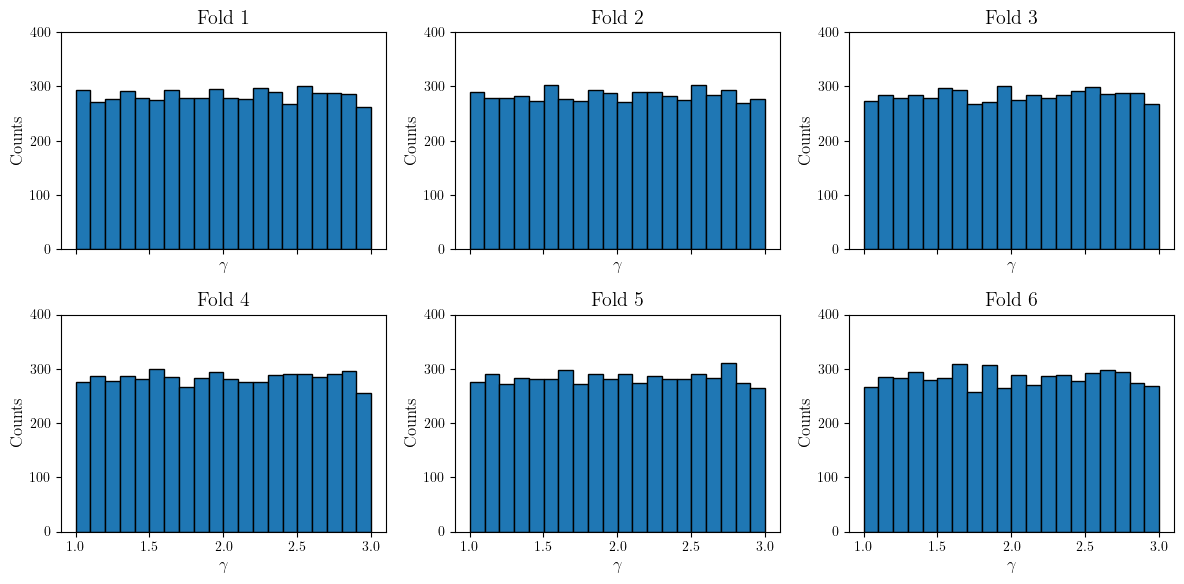

In [63]:
# Visualize target stratification in all folds

# Create subplots
list_of_arrays = valid_list
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex=True)

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate through each array in the list
for i, (array, ax) in enumerate(zip(list_of_arrays, axes)):

    # Extract the third or fourth columns of the array
    col_idx = 3
    third_column = array[:, col_idx]

    # Plot histogram
    ax.hist(third_column, bins=20, edgecolor='black')
    ax.set_title(f'Fold {i + 1}')
    if col_idx == 2:
        ax.set_ylim(0, 550)
        ax.set_xlabel('$E$ (kPa)')
    else:
        ax.set_ylim(0, 400)
        ax.set_xlabel('$\gamma$')

    ax.set_ylabel('Counts')

# Adjust layout
plt.tight_layout()
plt.show()

## ML

In [64]:
# Auxiliary functions

def create_model_dir(timestamp, contact_model: str):

  ''' Second input must be 'hertz' or 'jkr' '''
  
  allowed_models = ['hertz', 'jkr']
  if contact_model not in allowed_models:
    raise ValueError("Input value must be one of %s" % allowed_models)
  model_path = 'model_{}'.format(timestamp)
  parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
  if contact_model == 'hertz':
    dir = 'Hertz_models'
  elif contact_model == 'jkr':
    dir = 'JKR_models'
  path = os.path.join(parent_dir, dir, model_path)
  # path = os.path.join(initial_wd, dir, model_path)
  os.mkdir(path)
  os.chdir(path)

def data_as_pkl(dataset_list: list):
  file_names = ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test']
  new_dir = 'Train_Validation_Data'
  current_path = os.getcwd()
  os.mkdir(new_dir)
  os.chdir(new_dir)
  for i, array in enumerate(dataset_list):
    with open(file_names[i]+'.pkl', 'wb') as f:
      pickle.dump(array, f)
  os.chdir(current_path)

def plot_loss_curve2(epochs, mse_training, mse_validation, loss: bool, E:bool, gamma:bool):
  plt.ioff()
  plt.figure()
  plt.xlabel("Epoch")
  if loss:
    if E:
      plt.title("$E$", fontsize=16)
    elif gamma:
      plt.title("$\gamma$", fontsize=16)
    plt.ylabel("Loss")
    plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  else:
    if E:
      plt.title("$E$", fontsize=16)
    elif gamma:
      plt.title("$\gamma$", fontsize=16)
    plt.ylabel("Error (\%)")
    plt.plot(epochs[0:], mse_training[0:], label="Training Error")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Error")    
  plt.legend()
  # We're not going to plot the first epoch (>>greater loss)
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  top_of_y_axis = highest_loss + (delta * 0.2)
  bottom_of_y_axis = lowest_loss - (delta * 0.2)   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  if loss:
    if E:
      plt.savefig('loss_plot_E.pdf')
    elif gamma:
      plt.savefig('loss_plot_gamma.pdf')
    else:
      plt.savefig('loss_plot.pdf') 
  else:
    if E:
      plt.savefig('error_plot_E.pdf')
    elif gamma:
      plt.savefig('error_plot_gamma.pdf')
  # plt.show()
  plt.close()


def plot_bad_curves2(verror_list_E, verror_list_gamma, list_inputs, list_labels, test: bool):
  plt.ioff()
  verror_arr_E = np.array(verror_list_E)
  verror_arr_gamma = np.array(verror_list_gamma)
  v_error_arr = np.vstack((verror_arr_E, verror_arr_gamma)).T
  bad_curves = [(i, j) for i, j in enumerate(v_error_arr) if j[0] > 15 and j[1] > 15] # Gets index and error value of all errors above 15%
  if len(bad_curves) > 5:
    bad_curves = sorted(bad_curves, key= lambda k:max(k[1]), reverse=True)[:5]
  if len(bad_curves) < 5: 
    all_curves_sorted = sorted([(i, j) for i, j in enumerate(v_error_arr)], key= lambda k:max(k[1]), reverse=True) # sorts error list, keeping i (the original index of each error value)
    for i in range(5-len(bad_curves)):
        bad_curves.append(all_curves_sorted[len(bad_curves)+i])
  plt.figure()
  for j, (i, _) in enumerate(bad_curves):
      tensor_idx = i//len(list_inputs[0])
      tensor_fts, tensor_labels = list_inputs[tensor_idx], list_labels[tensor_idx]
      plt.plot(tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy(),
              tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy(),
              alpha=0.75,
              label=f'$E$={round(tensor_labels[i-tensor_idx*len(list_inputs[0]),0].item(),2)} kPa, $\epsilon_E$={verror_list_E[i]: .1f}\%, '+
                    f'$\gamma$={round(tensor_labels[i-tensor_idx*len(list_inputs[0]),1].item(),2)} $\mu$J/m$^2$, $\epsilon_\gamma$={verror_list_gamma[i]: .1f}\%')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  plt.legend()
  ax = plt.axis()
  plt.axis((ax[1],ax[0],ax[2],ax[3]))
  if test:
    plt.savefig('bad_curves_test.pdf')
  else:
    plt.savefig('bad_curves_valid.pdf')
  plt.close()

def plot_error_hist2(error_list, test: bool, E:bool, **kwargs):
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error2_5 = y, error10 = z)'''
  plt.ioff()
  # Define variable name to be introduced in the file name of the final plots
  if E:
    var_name = 'E'
  else:
    var_name = 'gamma'
  fig, ax = plt.subplots()
  plt.figure()
  x_values = [1, 2.5]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=20, density=True, ec='black', range=(0,6)) # to remove outliers, set parameter 'range='
  if E:
    ax.set_title("$E$", fontsize=16, y=1.08)
    ax.set_xlabel("Error $E$ (\%)")
  else:
    ax.set_title("$\gamma$", fontsize=16, y=1.08)
    ax.set_xlabel("Error $\gamma$ (\%)")
  ax.set_ylabel("Density")
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<1\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05))
    ax.text(0.74, 0.93, f'Synthetic test set ($n=$ {len(error_list)})', transform=ax.transAxes, fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    # ax.set_title("Test error")
    fig.savefig(f'error_hist_test_{var_name}.pdf')
  else:
    fig.savefig(f'error_hist_valid_{var_name}.pdf') 
  # plt.show()
  plt.close(fig)

def plot_pred_real_curves2(verror_list_E, verror_list_gamma, list_inputs, list_labels, test: bool, list_predicts, nu, r, E:bool):
  ''' Takes the list of errors and plots the curves with errors above 15%, and close to 10% and 2.5%.
      If plotting E, the list of errors for E is used, and only curves with gamma error below 2% are considered (and vice-versa).
      Inputs:
        - verror_list_E: list of errors for E 
        - verror_list_gamma: list of errors for gamma
        - list_inputs: list of tensors with inputs
        - list_labels: list of tensors with labels
        - test: boolean, True if test set, False if validation set
        - list_predicts: list of tensors with predictions
        - nu: Poisson's ratio
        - r: radius of the tip
        - E: boolean, True if plotting E, False if plotting gamma  
  '''
  plt.ioff()
  if E:
    var_name = 'E'
    idx = 0
    verror_list = verror_list_E
    verror_list2 = verror_list_gamma
  else:
    var_name = 'gamma'
    idx = 1
    verror_list = verror_list_gamma
    verror_list2 = verror_list_E
  # Get all index of the values in verror_list2 that are below 2%
  good_curves_2 = [i for i, j in enumerate(verror_list2) if j < 2.5]
  # Select the curves in verror_list with index i in good_curves_2
  verror_list = [verror_list[i] for i in good_curves_2]
  bad_curves = []
  bad_curves_15 = sorted([(i, j) for i, j in enumerate(verror_list) if j > 15], key= lambda k:k[1], reverse=True)
  bad_curves_10 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 10], key= lambda k:k[1], reverse=True)
  bad_curves_2 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 2], key= lambda k:k[1], reverse=True)
  all_bad_curves = [bad_curves_15, bad_curves_10, bad_curves_2]
  for curve in all_bad_curves:
    if len(curve) >=1:
      bad_curves.append(curve[0])
  # plt.figure()
  fig, ax = plt.subplots()
  colors = ['red','blue', 'green']
  line_styles = ['-', ':']
  for j, (i, _) in enumerate(bad_curves):
    tensor_idx = i//len(list_inputs[0])
    tensor_fts, tensor_labels, tensor_predicts = list_inputs[tensor_idx], list_labels[tensor_idx], list_predicts[tensor_idx]
    x = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy()
    y1 = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy()
    predict = tensor_predicts[i-tensor_idx*len(list_inputs[0]), idx].item()
    y2 = hertz(x, predict, nu, r)
    if E:
      ax.set_title("$E$", fontsize=16)
      ax.plot(x,
              y1,
              alpha=0.75,
              label='$E_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0]), 0].item(),3)} kPa, $\epsilon_E$={verror_list[i]: .2f} \%',
              color=colors[j], linestyle=line_styles[0])
    else:
      ax.set_title("$\gamma$", fontsize=16)
      ax.plot(x,
              y1,
              alpha=0.75,
              label='$\gamma_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0]), 1].item(),3)} $\mu$J/m$^2$, $\epsilon_\gamma$={verror_list[i]: .2f} \%',
              color=colors[j], linestyle=line_styles[0])
    ax.plot(x,
             y2,
             color=colors[j], linestyle=line_styles[1])
    color_legend = ax.legend()
  dummy_lines = []
  for k in range(2):
      dummy_lines.append(ax.plot([],[], c="black", ls = line_styles[k])[0])
  bbox_y = [0.85, 0.79, 0.73]
  linestyle_legend = plt.legend([dummy_lines[i] for i in [0,1]], ["Real curve", "Predicted Curve"], loc=7, bbox_to_anchor=(1.,bbox_y[len(bad_curves)-1]))
  # line_legend = ax.legend(loc='right')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  # plt.legend()
  ax.add_artist(color_legend)
  ax.add_artist(linestyle_legend)
  # put the legends in separate boxes
  color_legend.get_frame().set_facecolor('white')
  color_legend.get_frame().set_edgecolor('black')
  linestyle_legend.get_frame().set_facecolor('white')
  linestyle_legend.get_frame().set_edgecolor('black')
  # ax.add_artist(line_legend)
  ax2 = ax.axis()
  ax.axis((ax2[1],ax2[0],ax2[2],ax2[3]))
  if test:
      fig.savefig(f'test_pred_vs_real_curves_{var_name}.pdf')
  else:
      fig.savefig(f'valid_pred_vs_real_curves_{var_name}.pdf')
  plt.close(fig)

def error_fn(predict_tensor, label_tensor):
  '''
  INPUTS: * two tensors - true labels and predicts
  OUTPUTS: * scalar - mean relative error (in %) between both tensors
           * list - relative error (%) for each prediction
  '''
  error = abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).mean().item()
  error_list = list(abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).detach().numpy())
  return error, error_list

def scatter_true_pred(list_labels, list_preds, set: int, E: bool):
  '''Scatter plot of model predictions vs true outputs around a unitary slope line
    list_labels and list_preds: lists of one-valued tensors
    set: 0 - Validation, 1 - Test synthetic, 2 - Test experimental
    E: True if the Young's modulus is the variable being plotted'''
  plt.ioff()
  idx = 0 if E else 1
  if set == 2:
    labels_array = np.array([tensor.item() for tensor in list_labels])
    predicts_array = np.array([tensor.item() for tensor in list_preds])
  else:
    labels_array = list_labels[0][:,idx].detach().numpy()
    predicts_array = list_preds[0][:,idx].detach().numpy()     
  sets = ['valid', 'test_syn', 'test_exp']
  x = np.linspace(0,10.2,100)
  plt.plot(x,x, color='orange', linewidth=2, label="Ideal predictions",  alpha=0.8)
  plt.scatter(labels_array, predicts_array, alpha=0.5, edgecolors='black', label=f"Observations ($n =$ {len(labels_array)})")
  plt.legend(fontsize=14)
  if E:
    plt.xlabel("True $E$ (kPa)")
    plt.ylabel("Predicted $E$ (kPa)")
    plt.xlim(0,10.2)
    plt.ylim(0,10.2)
    plt.savefig('scatter_E_' + sets[set] + '.pdf', bbox_inches='tight')
  else:
    plt.xlabel("True $\gamma$ ($\mu$J/m$^2$)")
    plt.ylabel("Predicted $\gamma$ ($\mu$J/m$^2$)")
    plt.xlim(0.8,3.2)
    plt.ylim(0.8,3.2)    
    plt.savefig('scatter_gamma_' + sets[set] + '.pdf', bbox_inches='tight')
  plt.close()


In [65]:
class JKR_Dataset():
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [66]:
# Test Dataloader
test_data = JKR_Dataset(x_test_t_jkr, y_test_t_jkr)
test_loader=DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [67]:
################ After changing one of the hyperparameters: ########################
### Re-run the cells where the model class and the model_params dict are defined ###

# HYPERPARAMETERS
LEARNING_RATE = 2.99e-4 # 2.99e-4
EPOCHS = 110 # 110
BATCH_SIZE = 16 # 16

# Size of each layer
HIDDEN_UNITS_1 = 128 # 256
HIDDEN_UNITS_2 = 32 # 256
HIDDEN_UNITS_3 = 128 # 32

# 1: 2 layers, 2: 3 layers
ARCHITECTURE = 2

In [68]:
def prep_dataloader(dataset, train_ids, test_ids):
    train_data = dataset.iloc[train_ids]
    valid_data = dataset.iloc[test_ids]
    x_train = np.array(train_data[['withdraw_contact', 'f_jkr_contact']])
    y_train = np.array(train_data[['E_jkr', 'gamma_jkr']])
    x_valid = np.array(valid_data[['withdraw_contact', 'f_jkr_contact']])
    y_valid = np.array(valid_data[['E_jkr', 'gamma_jkr']])
    x_train_t = tensor_input_shape(x_train)
    y_train_t = torch.from_numpy(y_train).type(torch.float)
    x_valid_t = tensor_input_shape(x_valid)
    y_valid_t = torch.from_numpy(y_valid).type(torch.float)
    train_data = JKR_Dataset(x_train_t, y_train_t)
    valid_data = JKR_Dataset(x_valid_t, y_valid_t)
    train_loader=DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=False)
    valid_loader=DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
    return train_loader, valid_loader

In [69]:
# Define the regression model
class Regression_JKR(nn.Module):
        def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR):
            super(Regression_JKR, self).__init__()
            input_size = input_shape[0] * input_shape[1]
            self.layers = nn.Sequential(nn.Flatten(),
                                        nn.Linear(input_size, HIDDEN_UNITS_1_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_2_JKR,HIDDEN_UNITS_3_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_3_JKR, 2))
        def forward(self, x):
            out = self.layers(x)
            return out
    
# Define input shape
input_shape = x_train_t.shape[1:]
# Instantiate the model (add these two lines at the beggining of each fold cycle)
torch.manual_seed(42)
model_jkr = Regression_JKR(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3)

# Define the loss function and optimizer
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model_jkr.parameters(), 
                            lr=LEARNING_RATE)

In [70]:
model_params_jkr = {'Epochs': EPOCHS, 
                'Learning Rate': LEARNING_RATE,
                'Batch Size': BATCH_SIZE,
                'Number of Hidden layers': 3,
                'Type of layers': nn.Linear,
                'Activation function': nn.LeakyReLU(),
                'Architecture': ARCHITECTURE,
                'Hidden Units 1': HIDDEN_UNITS_1,
                'Hidden Units 2': HIDDEN_UNITS_2,
                'Hidden Units 3': HIDDEN_UNITS_3,
                'Input shape': list(input_shape),
                'Loss function': loss_fn,
                'Optimizer': optimizer}
model_params_jkr

{'Epochs': 110,
 'Learning Rate': 0.000299,
 'Batch Size': 16,
 'Number of Hidden layers': 3,
 'Type of layers': torch.nn.modules.linear.Linear,
 'Activation function': LeakyReLU(negative_slope=0.01),
 'Architecture': 2,
 'Hidden Units 1': 128,
 'Hidden Units 2': 32,
 'Hidden Units 3': 128,
 'Input shape': [50, 2],
 'Loss function': MSELoss(),
 'Optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.000299
     maximize: False
     weight_decay: 0
 )}

In [71]:
def train_one_epoch_jkr(epoch_index, train_loader, optimizer): # (epoch_index, tb_writer)
    # running_loss = 0.
    # last_loss = 0.
    loss_list = []
    error_E_list = []
    error_gamma_list = []
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer.zero_grad()
        predicts = model_jkr(inputs)
        # print(predicts)
        # Compute the loss and its gradients
        loss = loss_fn(predicts, labels).mean(dim=0)
        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))
        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))
        loss.backward(gradient=torch.Tensor([1., 1.]))
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        loss_list.append(loss.detach().numpy())
        error_E_list.append(error_E)
        error_gamma_list.append(error_gamma)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())
    return loss_list, error_E_list, error_gamma_list

In [72]:
def train_model_JKR(EPOCHS: int,
                      model,
                      tloader,
                      vloader,
                      loss_fn,
                      optimizer,
                      x_test_t, y_test_t,
                      model_params_jkr: dict,
                      ):
    plt.ioff()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Set new directory for new model
    # initial_wd = os.getcwd()
    create_model_dir(timestamp, contact_model='jkr')

    best_vloss = 1e15
    cols = ['Epoch', 'Train Loss', 'Mean Train Loss', 'Mean Val Loss', 
            'E - Train loss', 'E - Val loss','E - Train Error (%)', 'E - Mean Train Error (%)', 'E - Mean Val Error (%)', 
            'gamma - Train loss', 'gamma - Val loss','gamma - Train Error (%)', 'gamma - Mean Train Error (%)', 'gamma - Mean Val Error (%)']
    row = []
    # start timer counter
    start = datetime.now()
    for epoch in range(EPOCHS):
        # print(f'Epoch {epoch+1} of {EPOCHS}')
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        loss_list, error_E_list, error_gamma_list = train_one_epoch_jkr(epoch, tloader, optimizer) # loss_list is a np array
        loss_E = np.array(loss_list)[:,0].mean()
        loss_gamma = np.array(loss_list)[:,1].mean()
        # We don't need gradients on to do reporting
        model.train(False)
        running_vloss, running_verror_E, running_verror_gamma = 0.0, 0.0, 0.0
        running_vloss_E, running_vloss_gamma = 0.0, 0.0
        verror_E_list, verror_gamma_list, fts_list, labels_list, predicts_list = [], [], [], [], []
        # Validation cycle
        for i, vdata in enumerate(vloader):
            vinputs, vlabels = vdata
            fts_list.append(vinputs)
            labels_list.append(vlabels)
            voutputs = model(vinputs)
            predicts_list.append(voutputs)
            vloss = loss_fn(voutputs, vlabels).mean(dim=0)
            vloss_E = vloss[0].item()
            vloss_gamma = vloss[1].item()       
            verror_E, verror_E_aux_list = error_fn(voutputs[:,0].unsqueeze(dim=1), vlabels[:,0].unsqueeze(dim=1))
            verror_gamma, verror_gamma_aux_list = error_fn(voutputs[:,1].unsqueeze(dim=1), vlabels[:,1].unsqueeze(dim=1))
            running_vloss += vloss.detach().mean().item()
            running_vloss_E += vloss_E
            running_vloss_gamma += vloss_gamma
            running_verror_E += verror_E
            running_verror_gamma += verror_gamma
            verror_E_list += verror_E_aux_list
            verror_gamma_list += verror_gamma_aux_list
        
        avg_vloss = running_vloss / (i + 1)
        avg_vloss_E = running_vloss_E / (i + 1)
        avg_vloss_gamma = running_vloss_gamma / (i + 1)
        verror_list = [verror_E_list, verror_gamma_list]
        avg_verror_E = running_verror_E / (i + 1)
        avg_verror_gamma = running_verror_gamma / (i + 1)
        row.append(dict(zip(cols, 
                            [epoch+1, loss_list, np.array(loss_list).mean(), avg_vloss, 
                            loss_E, avg_vloss_E, error_E_list, np.array(error_E_list).mean(), avg_verror_E,
                            loss_gamma, avg_vloss_gamma, error_gamma_list, np.array(error_gamma_list).mean(), avg_verror_gamma])))
        # print(avg_verror_E, avg_verror_gamma, avg_vloss, loss_E)
        # print(error_E_list, error_gamma_list)
        # Track best performance
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_verror_E = avg_verror_E
            best_verror_gamma = avg_verror_gamma
            model_path = 'model_state_dict_{}_{}.pt'.format(timestamp, epoch+1)
            verror_E_list_best = verror_E_list
            verror_gamma_list_best = verror_gamma_list
            fts_list_best = fts_list
            labels_list_best = labels_list
            predicts_list_best = predicts_list
    end = datetime.now()
    model_params_jkr['Training Time'] = end - start
    print('Training time: {}'.format(model_params_jkr['Training Time']))
    print(f"Validation error - E (%): {best_verror_E}")
    print(f"Validation error - gamma (%): {best_verror_gamma}")
    torch.save(model.state_dict(), model_path)
    model_params_jkr['Model Path'] = model_path
    df = pd.DataFrame(row)
    df.to_csv('loss_error.csv', index=False)
    # plot_loss_curve2(df['Epoch'].values.tolist(), df['Mean Train Loss'].values.tolist(), df['Mean Val Loss'].values.tolist(), loss=True, E=False, gamma=False)
    # plot_loss_curve2(df['Epoch'].values.tolist(), df['E - Train loss'].values.tolist(), df['E - Val loss'].values.tolist(), loss=True, E=True, gamma=False)
    # plot_loss_curve2(df['Epoch'].values.tolist(), df['gamma - Train loss'].values.tolist(), df['gamma - Val loss'].values.tolist(), loss=True, E=False, gamma=True)
    # plot_loss_curve2(df['Epoch'].values.tolist(), df['E - Mean Train Error (%)'].values.tolist(), df['E - Mean Val Error (%)'].values.tolist(), loss=False, E=True, gamma=False)
    # plot_loss_curve2(df['Epoch'].values.tolist(), df['gamma - Mean Train Error (%)'].values.tolist(), df['gamma - Mean Val Error (%)'].values.tolist(), loss=False, E=False, gamma=True)
    # plot_bad_curves2(verror_E_list_best, verror_gamma_list_best, fts_list_best, labels_list_best, test=False)
    # plot_error_hist2(verror_E_list_best, test=False, E=True)
    # plot_error_hist2(verror_gamma_list_best, test=False, E=False)
    scatter_true_pred(labels_list_best, predicts_list_best, set = 0, E = True)
    scatter_true_pred(labels_list_best, predicts_list_best, set = 0, E = False)
    with open('model_params.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = model_params_jkr.keys())
        writer.writeheader()
        writer.writerow(model_params_jkr)
    print(x_test_t.shape, y_test_t.shape)
    torch.save(x_test_t, 'x_test_t.pt')
    torch.save(y_test_t, 'y_test_t.pt')
    # os.chdir(initial_wd)

In [73]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               error_fn):
    plt.ioff()
    model.eval()
    loss, loss_E, loss_gamma, error_E, error_gamma, avg_loss  = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    error_E_list, error_gamma_list, fts_list, labels_list, predicts_list = [], [], [], [], []
    with torch.inference_mode():
        for i, testdata in enumerate(data_loader):
            test_fts, test_labels = testdata
            fts_list.append(test_fts)
            labels_list.append(test_labels)
            y_pred = model(test_fts)
            predicts_list.append(y_pred)
            # LOSS 
            loss = loss_fn(y_pred, test_labels).mean(dim=0)
            loss_E += loss[0].item()
            loss_gamma += loss[1].item()
            avg_loss += loss.mean().item()
            # ERROR
            error_E_aux, error_E_aux_list = error_fn(y_pred[:,0].unsqueeze(dim=1), test_labels[:,0].unsqueeze(dim=1))
            error_gamma_aux, error_gamma_aux_list = error_fn(y_pred[:,1].unsqueeze(dim=1), test_labels[:,1].unsqueeze(dim=1)) ########
            error_E += error_E_aux
            error_gamma += error_gamma_aux
            error_E_list += error_E_aux_list
            error_gamma_list += error_gamma_aux_list
        avg_loss /= len(data_loader)
        loss_E /= len(data_loader)
        loss_gamma /= len(data_loader)
        error_E /= len(data_loader)
        error_gamma /= len(data_loader)
    np.save('error_list_E_test_syn.npy', np.array(error_E_list))
    error1_E = len([i for i in error_E_list if i <= 1])/len(error_E_list)
    error2_5_E = len([i for i in error_E_list if i <= 2.5])/len(error_E_list)
    error5_E = len([i for i in error_E_list if i <= 5])/len(error_E_list)
    error10_E = len([i for i in error_E_list if i <= 10])/len(error_E_list)
    np.save('error_list_gamma_test_syn.npy', np.array(error_gamma_list))
    error1_gamma = len([i for i in error_gamma_list if i <= 1])/len(error_gamma_list)
    error2_5_gamma = len([i for i in error_gamma_list if i <= 2.5])/len(error_gamma_list)
    error5_gamma = len([i for i in error_gamma_list if i <= 5])/len(error_gamma_list)
    error10_gamma = len([i for i in error_gamma_list if i <= 10])/len(error_gamma_list)
    print(f"Test Error - E (%): {error_E}")
    print(f"Test Curves under 5% - E (%): {error5_E*100}")
    print(f"Test Error - gamma (%): {error_gamma}")
    print(f"Test Curves under 5% - gamma (%): {error5_gamma*100}")
    results_dict_E = {"model_name": model.__class__.__name__,
                    "model_loss": loss_E,
                    "model_error": error_E,
                    "under_1%_error": error1_E,
                    "under_2.5%_error": error2_5_E,
                    "under_5%_error": error5_E,
                    "under_10%_error": error10_E}
    
    results_dict_gamma = {"model_name": model.__class__.__name__,
                        "model_loss": loss_gamma,
                        "model_error": error_gamma,
                        "under_1%_error": error1_gamma,
                        "under_2.5%_error": error2_5_gamma,
                        "under_5%_error": error5_gamma,
                        "under_10%_error": error10_gamma}
    
    with open('test_results_E.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict_E.keys())
        writer.writeheader()
        writer.writerow(results_dict_E)
    with open('test_results_gamma.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict_gamma.keys())
        writer.writeheader()
        writer.writerow(results_dict_gamma)
        
    plot_error_hist2(error_E_list, test=True, E=True, error1=error1_E, error2=error2_5_E)
    plot_error_hist2(error_gamma_list, test=True, E=False, error1=error1_gamma, error2=error2_5_gamma)
    plot_bad_curves2(error_E_list, error_gamma_list, fts_list, labels_list, test=True)
    plot_pred_real_curves2(error_E_list, error_gamma_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r, E=True)
    plot_pred_real_curves2(error_E_list, error_gamma_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r, E=False)
    scatter_true_pred(labels_list, predicts_list, set = 1, E = True)
    scatter_true_pred(labels_list, predicts_list, set = 1, E = False)
    print(results_dict_E)
    print(results_dict_gamma)

In [74]:
# Perform Cross-Validation ()
plt.ioff() # Turn off plotting display
k_folds = 6

# Stratified K-fold cross validator
skf = StratifiedKFold(n_splits=k_folds, shuffle=False, random_state=None)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, valid_ids) in enumerate(skf.split(train_df_jkr, train_df_jkr['combined_targets'])):
    os.chdir(initial_wd)
    # Prints
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    if fold == 4:
        # Dataset and DataLoader stuff
        train_loader, valid_loader = prep_dataloader(dataset=train_df_jkr, train_ids=train_ids, test_ids=valid_ids)            

        # Initialize the NN
        input_shape = x_train_t.shape[1:]
        torch.manual_seed(42)
        model_jkr = Regression_JKR(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3)
        optimizer = torch.optim.Adam(model_jkr.parameters(), 
                                lr=LEARNING_RATE)
        # Start Training + Validation
        print("Training ...")
        plt.ioff()
        train_model_JKR(EPOCHS, model_jkr, train_loader, valid_loader, loss_fn, optimizer, x_test_t_jkr, y_test_t_jkr, model_params_jkr)
        
        # Start testing
        print("Testing on synthetic data...")
        eval_model(model_jkr, test_loader, loss_fn, error_fn)
        print('--------------------------------')

--------------------------------
FOLD 1
--------------------------------
FOLD 2
--------------------------------
FOLD 3
--------------------------------
FOLD 4
--------------------------------
FOLD 5
--------------------------------


c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\venv\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


Training ...
Training time: 0:08:17.712866
Validation error - E (%): 0.5426933169364929
Validation error - gamma (%): 1.0025688409805298
torch.Size([6000, 50, 2]) torch.Size([6000, 2])
Testing on synthetic data...
Test Error - E (%): 0.49504733085632324
Test Curves under 5% - E (%): 99.5
Test Error - gamma (%): 1.366005539894104
Test Curves under 5% - gamma (%): 98.26666666666667
{'model_name': 'Regression_JKR', 'model_loss': 0.0003979377797804773, 'model_error': 0.49504733085632324, 'under_1%_error': 0.8935, 'under_2.5%_error': 0.9791666666666666, 'under_5%_error': 0.995, 'under_10%_error': 0.9991666666666666}
{'model_name': 'Regression_JKR', 'model_loss': 0.001038929563947022, 'model_error': 1.366005539894104, 'under_1%_error': 0.4685, 'under_2.5%_error': 0.8653333333333333, 'under_5%_error': 0.9826666666666667, 'under_10%_error': 0.9986666666666667}
--------------------------------
FOLD 6
--------------------------------


In [75]:
os.chdir(initial_wd)
os.getcwd()

'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface'